In [1]:
%load_ext autoreload
%autoreload 2

Normal Limit Distribution
---

1.3308265209197998


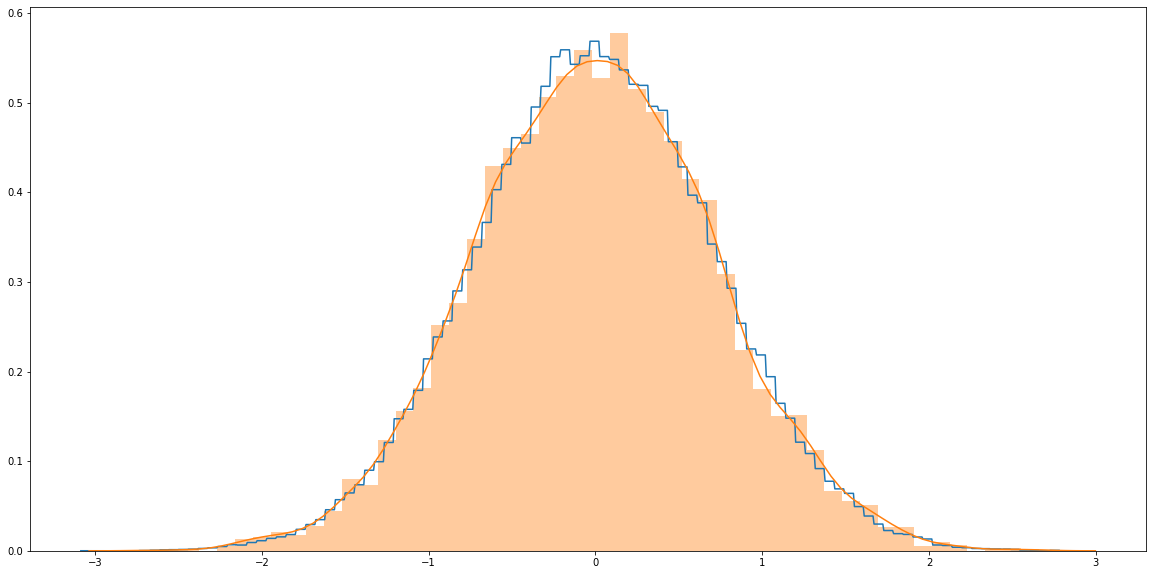

In [2]:
from sdepy.master import run
from sdepy.sde.ito import Ito1D
from sdepy.pdf.histogram import Simple1DHistogram
from sdepy.core import Job
import functions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import time


T = 0.5
sde = Ito1D(particles=25000,
            x0=0.0,
            drift=functions.drift,
            diffusion=functions.diffusion,
            sigma=1,
            t0=0.0,
            dt=1e-3,
            T=T)

job = Job(
    sde=sde,
    pdf=Simple1DHistogram(bins=100),
    mode=Job.RAW,
    settings={}
)

timestamp = time.time()
pdf = run(job, processes=4, parent=functions.__file__).distributions[-1]
print(time.time() - timestamp)

x = np.linspace(pdf.lower_bound, pdf.upper_bound, 1000)
y = pdf(x)

plt.figure(figsize=(20, 10))
plt.plot(x, y, label="Approximation")
sb.distplot(np.random.normal(0, np.sqrt(T), size=10000), label="True")
plt.show()


Exponential Limit Distribution
---

1.4349777698516846


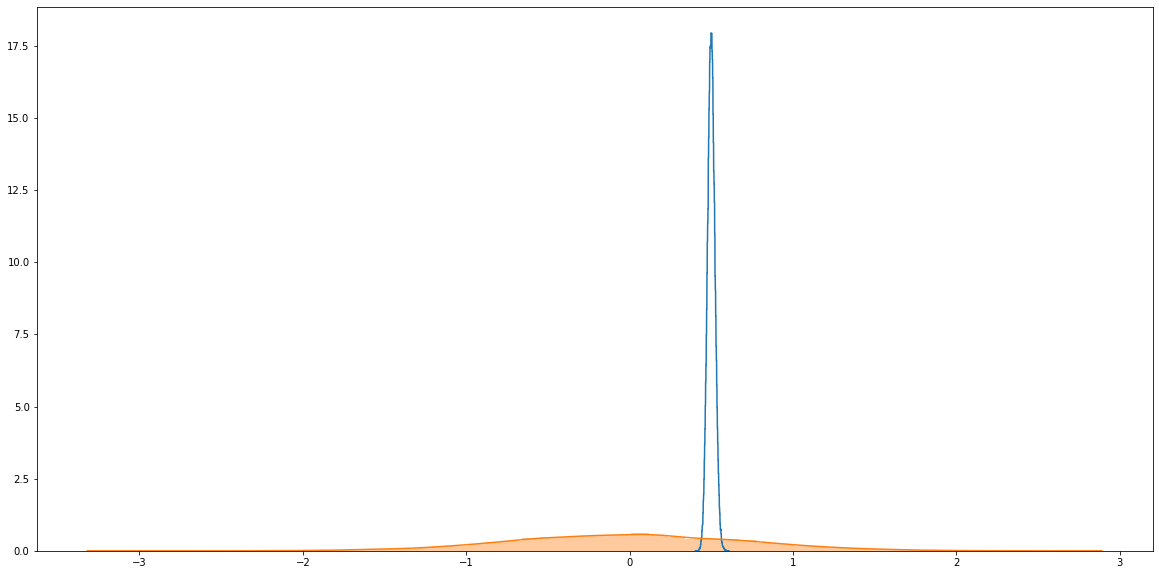

In [3]:
from sdepy.sde.exp import Exp1D


T = 0.5
sde = Exp1D(particles=25000,
            x0=0.0,
            drift=functions.drift,
            diffusion=functions.diffusion,
            lam=1,
            t0=0.0,
            dt=1e-3,
            T=T)

job = Job(
    sde=sde,
    pdf=Simple1DHistogram(bins=100),
    mode=Job.RAW,
    settings={}
)

timestamp = time.time()
pdf = run(job, processes=4, parent=functions.__file__).distributions[-1]
print(time.time() - timestamp)

x = np.linspace(pdf.lower_bound, pdf.upper_bound, 1000)
y = pdf(x)

plt.figure(figsize=(20, 10))
plt.plot(x, y, label="Approximation")
sb.distplot(np.random.normal(0, np.sqrt(T), size=10000), label="True")
plt.show()


Some Normal Process
---

In [4]:
from sdepy.video import make_time_1dx_distplot_video
from IPython.display import HTML
import matplotlib.pyplot as plt
import functions


print(functions.drift(2, 2))

T = 0.5
dt = 1e-3
sde = Ito1D(particles=25000,
            x0=0.0,
            drift=functions.drift,
            diffusion=functions.diffusion,
            sigma=1,
            t0=0.0,
            dt=dt,
            T=T)

job = Job(
    sde=sde,
    pdf=Simple1DHistogram(bins=100),
    mode=Job.Video,
    settings={"steps_per_frame": 5}
)

result = run(job, processes=2).distributions

anim = make_time_1dx_distplot_video(result, fps=10, dt=dt, steps_per_frame=5, save=True)
anim.fps = 10
anim.bitrate = 1800

plt.close()


HTML(anim.to_html5_video())

0


Some Exponential Process
---

In [6]:
from sdepy.video import make_time_1dx_distplot_video
from IPython.display import HTML
import matplotlib.pyplot as plt
import functions


print(functions.drift(2, 2))

T = 0.5
dt = 1e-3
sde = Exp1D(particles=25000,
            x0=0.0,
            drift=functions.drift,
            diffusion=functions.diffusion,
            lam=1,
            t0=0.0,
            dt=dt,
            T=T)

job = Job(
    sde=sde,
    pdf=Simple1DHistogram(bins=100),
    mode=Job.Video,
    settings={"steps_per_frame": 5}
)

result = run(job, processes=2).distributions

anim = make_time_1dx_distplot_video(result, fps=10, dt=dt, steps_per_frame=5, save=True)
anim.fps = 10
anim.bitrate = 1800

plt.close()


HTML(anim.to_html5_video())

0


Modelling Corona with exponential process
---

In [10]:
from sdepy.video import make_time_1dx_distplot_video
from IPython.display import HTML
import matplotlib.pyplot as plt
import functions

functions.has_been_sick = None

T = 200
dt = 1e-1
sde = Exp1D(particles=25000,
            x0=1.0,
            drift=functions.covid_drift,
            diffusion=functions.covid_diffusion,
            lam=1,
            t0=0.0,
            dt=dt,
            T=T)

job = Job(
    sde=sde,
    pdf=Simple1DHistogram(bins=100),
    mode=Job.Video,
    settings={"steps_per_frame": 5}
)

result = run(job, processes=4).distributions

anim = make_time_1dx_distplot_video(result, fps=10, dt=dt, steps_per_frame=5, save=True)
anim.fps = 10
anim.bitrate = 1800

plt.close()


HTML(anim.to_html5_video())

In [194]:
import functions

#functions.has_been_sick = None
print(functions.has_been_sick)
print(functions.covid_diffusion(0, 1))
functions.covid_drift(0, 1)

0.2714285714285714
1.9999923047132244


0.9928571428571429